In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
from src.datareader import datareader as dr

<h3>Initialize Data Readers</h3>

In [2]:
# This example uses low-resolution ERA5 data to demonstrate regridding of UFS data.
data_reader1 = dr.getDataReader(datasource='UFS', model='atm')
data_reader2 = dr.getDataReader(datasource='ERA5', filename='1959-2022-6h-240x121_equiangular_with_poles_conservative.zarr')

# Alternatively, you could get higher resolution ERA5 data like 'gs://gcp-public-data-arco-era5/ar/1959-2022-6h-512x256_equiangular_conservative.zarr'
# which is the default ERA5 dataset (if you don't manually specify the 'filename' argument).

No filename provided; deferring to default
Reading data from s3://noaa-oar-sfsdev-pds/experiments/phase_1/baseline/atm_monthly.zarr
Standardizing coordinate system
Dataset ready.
Reading data from gs://gcp-public-data-arco-era5/ar/1959-2022-6h-240x121_equiangular_with_poles_conservative.zarr
Standardizing coordinate system
Dataset ready.


<h3>Describe</h3>

In [3]:
# This method prints a table of every variable, its dimensions, shape, description, and units
# data_reader1.describe()
# data_reader2.describe()

In [4]:
# It can also print a quick summary of a particular variable.
data_reader1.describe('tprs')
data_reader2.describe('u_component_of_wind')


Variable: tprs
Dimensions: ('init', 'member', 'lead', 'lev', 'lat', 'lon')
Shape: (60, 11, 4, 39, 192, 384)
Attributes:
  - long_name: Temperature
  - units: K

Variable: u_component_of_wind
Dimensions: ('time', 'lat', 'lon', 'lev')
Shape: (92040, 121, 240, 13)
Attributes:
  - long_name: U component of wind
  - short_name: u
  - standard_name: eastward_wind
  - units: m s**-1


<h3>Retrieve DataSets</h3>

In [5]:
# Let's get data for 1 init and lead cycle (1 init + 3 leads)
time_range = ('2021-05-01', '2021-08-30T23')

In [6]:
# Retrieve a UFS dataset (Xarray object). The complete dataset is preserved after retrieval.
ds1 = data_reader1.retrieve(
    var=["tprs", "uprs", "vprs"],
    # var = 'tmp2m',
    # lat=(30, 50),
    # lon=(240, 280),
    lev=500,
    time=time_range,
    # member = (2, 5)
    ens_avg=True
) 

Slicing by init
Slicing by model dimension lev
Taking Ensemble Average


In [7]:
# Retrieve a corresponding ERA5 dataset (Xarray object). The complete dataset is preserved after retrieval.
ds2 = data_reader2.retrieve(
    var=['temperature', 'u_component_of_wind', 'v_component_of_wind'],
    # lat=(30, 50),
    # lon=(240, 280),
    lev=500,
    time=time_range
)

Slicing by time
Slicing by lev


In [9]:
# Display Xarray datasets
# ds1
# ds2

<h1>Regrid</h1>

In [10]:
from src.regridder import Regrid

<h3>Initialize Regridder</h3>

In [11]:
# The Regrid class takes in two DataReader objects.
# Available interpolation methods are ['bilinear', 'conservative', 'patch', 'nearest_s2d', 'nearest_d2s']
regridder = Regrid.Regrid(data_reader1=data_reader1,
                          data_reader2=data_reader2,
                          method='bilinear')

Regrid Object initialized.

___Resample Instructions___
data_reader2 must be temporally resampled before spatially regridding.
Resample these data by running <RegridObj>.resample(var=<var>, lev=<lev>, time=<time_range>)
To see all variables available for resample, run <RegridObj>.resample_vars()

___Regrid Instructions___
Initialized the Regridder with method 'bilinear'
Input grid shape data_reader1 (UFS_DataReader): lat 192, lon 384
Output grid shape data_reader2 (ERA5_DataReader): lat 121, lon 240
Regrid these data by running <RegridObj>.regrid(var=<var>, lev=<lev>, time=<time_range>)
To see all variables available for regrid, run <RegridObj>.regrid_vars()

___Align Instructions___
data_reader2 can have its time coordinates converted to init+lead.
Lead resolution of the UFS dataset interpreted as monthly intervals.
Align these data by running <RegridObj>.align()  (Note: May need to resample and/or regrid first.)


In [12]:
# Print a list of variables from the ERA5 dataset that can and should be resampled before regridding.
regridder.resample_vars()

Variables available for Resample (data_reader2):
                                                                                      
10m_u_component_of_wind               standard_deviation_of_filtered_subgrid_orography
10m_v_component_of_wind               standard_deviation_of_orography                 
10m_wind_speed                        surface_pressure                                
2m_temperature                        temperature                                     
angle_of_sub_gridscale_orography      toa_incident_solar_radiation                    
anisotropy_of_sub_gridscale_orography toa_incident_solar_radiation_12hr               
geopotential                          toa_incident_solar_radiation_24hr               
geopotential_at_surface               toa_incident_solar_radiation_6hr                
high_vegetation_cover                 total_cloud_cover                               
lake_cover                            total_column_water_vapour                  

In [13]:
# Print a list of variables that can be regridded, i.e. variables in the higher resolution dataset.
regridder.regrid_vars()

Variables available for Regrid (data_reader1):
                              
albdo   phi      soilt  taux  
capesfc prate    soilw  tauy  
gflux   pwat     spfh   tcc   
lwdsfc  siconc   spfh2m tmp2m 
lwusfc  sithick  ssrun  tmpsfc
lwutoa  slp      swdsfc tozne 
mslhf   snod     swdtoa tprs  
msshf   snowc    swe    uprs  
o3mr    snowfall swusfc vprs  
pevpr   soill    swutoa watr  


In [14]:
# Here we resample non-UFS data to match the UFS dataset's lead resolution.
# If multiple processors are available on your machine, make use of them by setting use_mp=True for parallel computation.
regridder.resample(var='temperature',
                   lev=500,
                   time=time_range,
                   use_mp=False)

Slicing by time
Slicing by lev
Resampling data_reader2 data to 'MS' using mean aggregation.
Resampling from 2021-05-01T00 to 2021-08-30T18
Resampling completed in 0.04 minutes.
Standardizing coordinate system
Dataset ready.
Resample results stored in <RegridObj>.resampled


In [15]:
# The results of the .resample() method are DataReader objects that are stored in the .resampled attribute. 
# You can view the entire result of .resample() like this:
regridder.resampled.dataset()

<xarray.Dataset> Size: 468kB
Dimensions:      (time: 4, lat: 121, lon: 240)
Coordinates:
  * lat          (lat) float64 968B 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * lon          (lon) float64 2kB 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
  * time         (time) datetime64[ns] 32B 2021-05-01 2021-06-01 ... 2021-08-01
Data variables:
    temperature  (time, lat, lon) float32 465kB 239.5 239.5 ... 228.6 228.6

In [16]:
# Or, as shown above, you can run a retrieve to get a slice of the data, like this:
regridder.resampled.retrieve(var='temperature', time='2021-05-01', lat=(30, 50), lon=(240, 280))
# Note: If you're working on your own machine, you can
# save the results to an .nc or .csv file with save_path='/absolute/path/to/file.nc'

Slicing by lat
Slicing by lon
Slicing by time


<xarray.Dataset> Size: 2kB
Dimensions:      (lat: 13, lon: 26)
Coordinates:
  * lat          (lat) float64 104B 49.5 48.0 46.5 45.0 ... 36.0 34.5 33.0 31.5
  * lon          (lon) float64 208B 241.5 243.0 244.5 ... 276.0 277.5 279.0
Data variables:
    temperature  (lat, lon) float32 1kB 252.2 252.4 252.7 ... 263.2 263.2 263.1

In [17]:
# This is the crux of the Regrid class, the .regrid() method.
# If a UFS dataset is being regridded, make sure to either specifiy an ensemble member or set ens_avg=True.
# If the ERA5 dataset is regridded, you will be required (!) to run the .resample() method first for your variable of interest.
regridder.regrid(var='tprs',
                 lev=500,
                 time=time_range,
                 ens_avg=True)

Regridding data_reader1 grid (UFS_DataReader) onto data_reader2 grid (ERA5_DataReader)
Slicing by init
Slicing by init
Slicing by model dimension lev
Taking Ensemble Average
Running scalar regrid on tprs
Completed scalar regrid in 0.03 minutes.
Standardizing coordinate system
Dataset ready.
Regrid results stored in <RegridObj>.regridded


In [18]:
# The results of the .regrid() method are DataReader objects that are stored in the .regridded attribute. 
# You can view the entire result of .regrid() like this:
regridder.regridded.dataset()

<xarray.Dataset> Size: 468kB
Dimensions:  (init: 1, lead: 4, lat: 121, lon: 240)
Coordinates:
  * init     (init) datetime64[ns] 8B 2021-05-01
  * lead     (lead) int64 32B 0 1 2 3
  * lat      (lat) float64 968B 90.0 88.5 87.0 85.5 ... -85.5 -87.0 -88.5 -90.0
  * lon      (lon) float64 2kB 0.0 1.5 3.0 4.5 6.0 ... 354.0 355.5 357.0 358.5
Data variables:
    tprs     (init, lead, lat, lon) float32 465kB dask.array<chunksize=(1, 1, 121, 240), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [25]:
# Or, as shown above, you can run a retrieve to get a slice of the data, like this:
regridder.regridded.retrieve(var='tprs', lat=(30, 50), lon=(240, 280))
# Note: If you're working on your own machine, you can
# save the results to an .nc or .csv file with save_path='/absolute/path/to/file.nc'

Slicing by lat
Slicing by lon


<xarray.Dataset> Size: 6kB
Dimensions:  (init: 1, lead: 4, lat: 13, lon: 26)
Coordinates:
  * init     (init) datetime64[ns] 8B 2021-05-01
  * lead     (lead) int64 32B 0 1 2 3
  * lat      (lat) float64 104B 49.5 48.0 46.5 45.0 43.5 ... 36.0 34.5 33.0 31.5
  * lon      (lon) float64 208B 241.5 243.0 244.5 246.0 ... 276.0 277.5 279.0
Data variables:
    tprs     (init, lead, lat, lon) float32 5kB dask.array<chunksize=(1, 1, 13, 26), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [26]:
# The final step in a standard workflow is to align a time coordinate (say, for the ERA5 dataset) to the UFS's init+lead coordinate structure.
# You may or may not want to do this, depending on how you wish to work with your data.
# If an ERA5 dataset was regridded, then that result will be aligned.
# If there is an ERA5 dataset but it is NOT the dataset being regridded, then the resampled result will be aligned.
regridder.align()

Aligning time coordinate to init+lead coordinates.
Slicing by init
Time dimensions aligned:  matched 4 timesteps
Standardizing coordinate system
Dataset ready.
Align results stored in <RegridObj>.aligned


In [27]:
# The results of the .align() method are DataReader objects that are stored in the .aligned attribute. 
# You can view the entire result of .align() like this:
regridder.aligned.dataset()

<xarray.Dataset> Size: 468kB
Dimensions:      (lat: 121, lon: 240, lead: 4, init: 1)
Coordinates:
  * lat          (lat) float64 968B 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * lon          (lon) float64 2kB 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
    time         (lead) datetime64[ns] 32B 2021-05-01 2021-06-01 ... 2021-08-01
  * lead         (lead) int64 32B 0 1 2 3
  * init         (init) datetime64[ns] 8B 2021-05-01
Data variables:
    temperature  (init, lead, lat, lon) float32 465kB 239.5 239.5 ... 228.6
Attributes:
    model_freq_unit:      MS
    lead_step:            30 days
    alignment_tolerance:  16 days

In [28]:
# Or, as shown above, you can run a retrieve to get a slice of the data, like this:
regridder.aligned.retrieve(var='temperature', lat=(30, 50), lon=(240, 280))
# Note: If you're working on your own machine, you can
# save the results to an .nc or .csv file with save_path='/absolute/path/to/file.nc'

Slicing by lat
Slicing by lon


<xarray.Dataset> Size: 6kB
Dimensions:      (init: 1, lead: 4, lat: 13, lon: 26)
Coordinates:
  * lat          (lat) float64 104B 49.5 48.0 46.5 45.0 ... 36.0 34.5 33.0 31.5
  * lon          (lon) float64 208B 241.5 243.0 244.5 ... 276.0 277.5 279.0
  * lead         (lead) int64 32B 0 1 2 3
  * init         (init) datetime64[ns] 8B 2021-05-01
Data variables:
    temperature  (init, lead, lat, lon) float32 5kB 252.2 252.4 ... 266.9 266.7
Attributes:
    model_freq_unit:      MS
    lead_step:            30 days
    alignment_tolerance:  16 days

<h1>Plot the results</h1>

<h3>Run these cells if you regridded a scalar variable like temperature</h3>

In [29]:
def plot_robinson(dataslice, title):

    projection = ccrs.Robinson()
    crs = ccrs.PlateCarree()
    
    plt.figure(figsize=(14,7), dpi=100)
    ax = plt.axes(projection=projection)
    ax.set_global()
    dataslice.plot(ax=ax, transform=crs) #, vmin=200, vmax=320)
    ax.coastlines()
    
    if 'time' in list(dataslice.coords):
        title = f"{title} TIME {str(dataslice.time.values)}"
        
    elif 'init' in list(dataslice.coords):
        title = f"{title} INIT {str(dataslice.init.values)}"
        
    plt.title(f"{title}")
    
    return plt

<module 'matplotlib.pyplot' from '/home/thamzey/miniforge2/envs/ufs_model_evaluation_py311/lib/python3.11/site-packages/matplotlib/pyplot.py'>

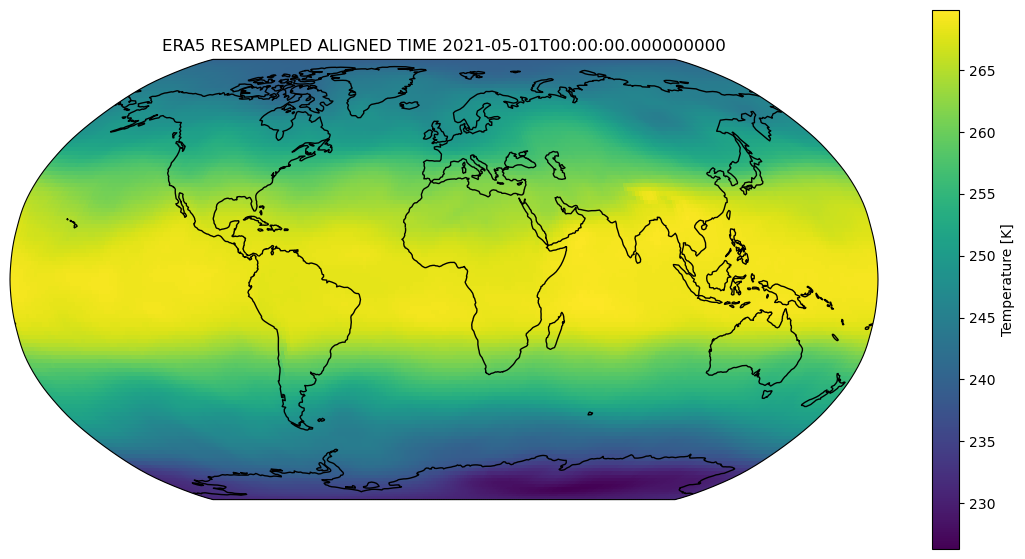

In [30]:
# Plot the first "init" of the *resampled* and aligned ERA5 data.
dataslice = regridder.aligned.dataset().isel(init=0, lead=0)['temperature']
plot_robinson(dataslice, 'ERA5 RESAMPLED ALIGNED')
# Does this plot pass the eye test?

<module 'matplotlib.pyplot' from '/home/thamzey/miniforge2/envs/ufs_model_evaluation_py311/lib/python3.11/site-packages/matplotlib/pyplot.py'>

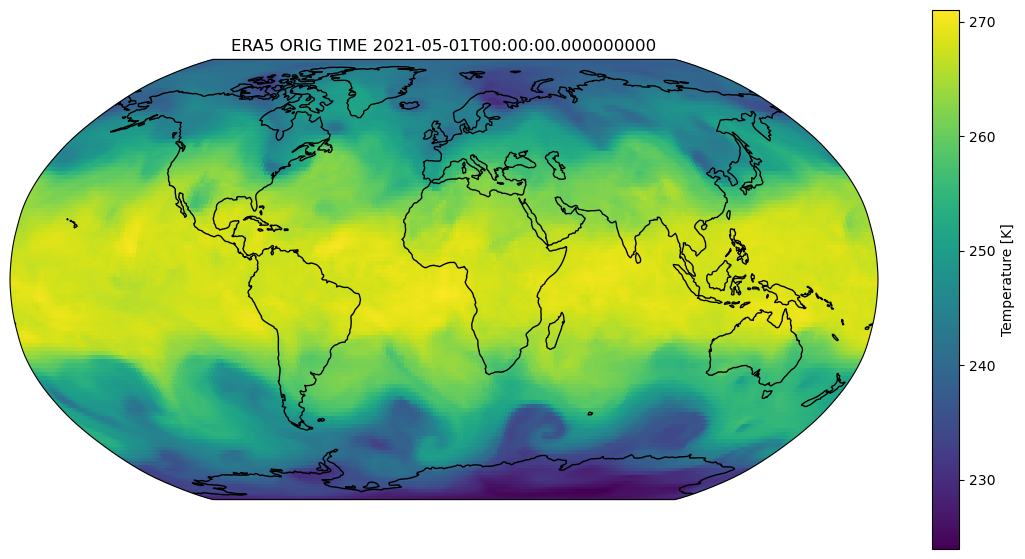

In [31]:
# Compare that to the original ERA5 dataset for the first *timestep* in our time_range
dataslice = ds2['temperature'].isel(time=0)
plot_robinson(dataslice, 'ERA5 ORIG')

<module 'matplotlib.pyplot' from '/home/thamzey/miniforge2/envs/ufs_model_evaluation_py311/lib/python3.11/site-packages/matplotlib/pyplot.py'>

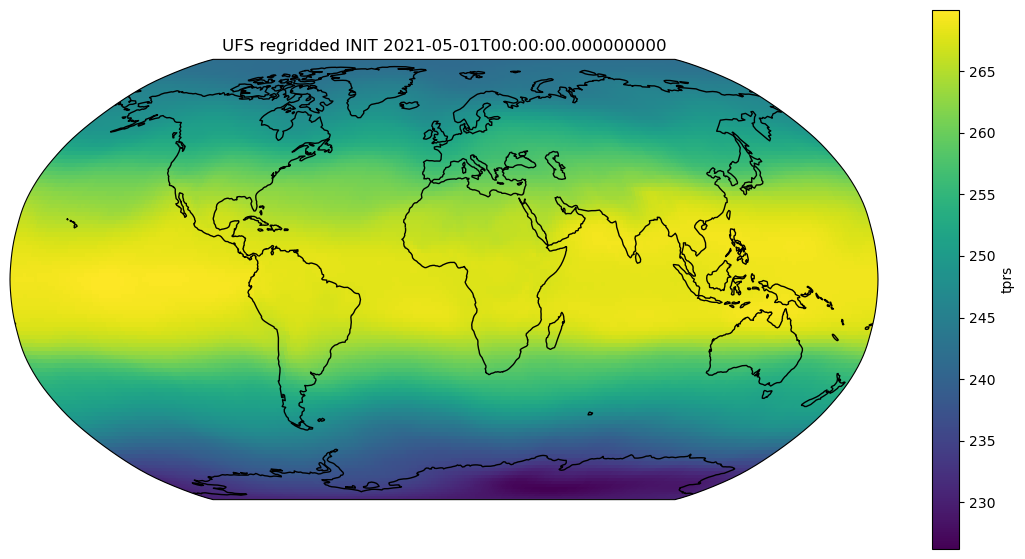

In [37]:
# Now let's compare the regridded UFS result against its resampled and aligned ERA5 equivalent.
# Note that we need to manually exclude the poles because their bilinearly interpolated values are meaningless.
# This is the regridded UFS dataset at the first init:
dataslice = regridder.regridded.dataset().isel(init=0, lead=0)['tprs']
dataslice = dataslice.where(dataslice.lat != -90).where(dataslice.lat != 90)
plot_robinson(dataslice, 'UFS regridded')

<module 'matplotlib.pyplot' from '/home/thamzey/miniforge2/envs/ufs_model_evaluation_py311/lib/python3.11/site-packages/matplotlib/pyplot.py'>

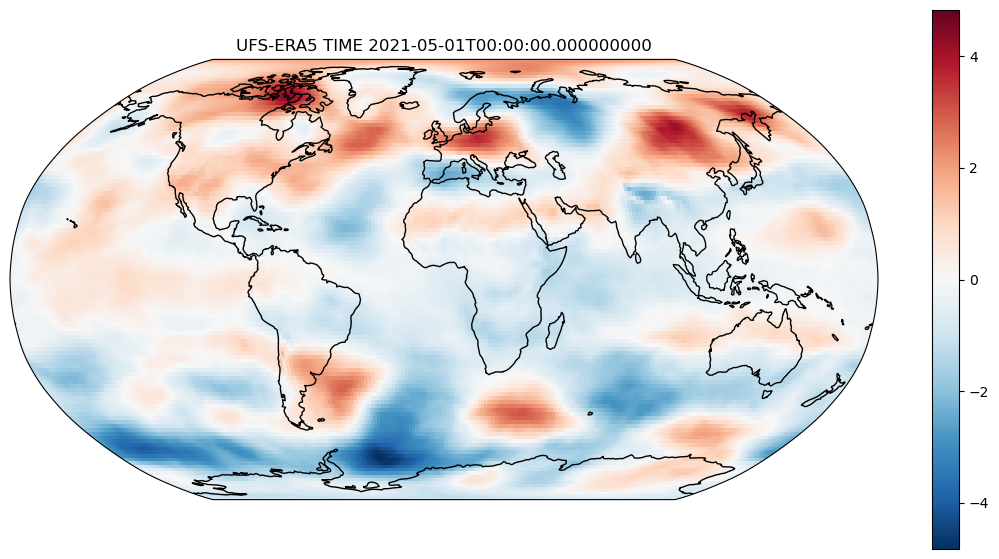

In [38]:
# And this is the difference between the UFS regridded and the ERA5 data:
dataslice = dataslice - regridder.aligned.dataset().isel(init=0, lead=0)['temperature']
plot_robinson(dataslice, 'UFS-ERA5')